In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pickle
import copy
import itertools
from collections import deque

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [15]:
class GameEnvironment:
    def __init__(self):
        self.hand = []
        self.hand_history = []
        self.score_potentials = []
        self.rolls_left = 3
        self.turns_left = 13
        self.top_bonus = False
        self.score_card = {
            'ones': -1, 'twos': -1, 'threes': -1, 'fours': -1, 'fives': -1, 'sixes': -1,
            'three_of_a_kind': -1, 'four_of_a_kind': -1, 'full_house': -1, 'small_straight': -1,
            'large_straight': -1, 'yahtzee': -1, 'chance': -1, 'total_score': 0
        }
        self.max_score_potentials = {
            'ones': 5, 'twos': 10, 'threes': 15, 'fours': 20, 'fives': 25, 'sixes': 30,
            'three_of_a_kind': 30, 'four_of_a_kind': 30, 'full_house': 25, 'small_straight': 30,
            'large_straight': 40, 'yahtzee': 50, 'chance': 30, 'total_score': 340
        }
        self.label_score_dict = {
            0: 'ones', 1: 'twos', 2: 'threes', 3: 'fours', 4: 'fives', 5: 'sixes',
            6: 'three_of_a_kind', 7: 'four_of_a_kind', 8: 'full_house', 9: 'small_straight', 
            10: 'large_straight', 11: 'yahtzee', 12: 'chance'
        }
        self.hand_combinations = list(itertools.combinations_with_replacement(range(1, 7), 5))
        self.hand_int_dict = {hand: i for i, hand in enumerate(self.hand_combinations)}
        self.int_hand_dict = {i: hand for i, hand in enumerate(self.hand_combinations)}
    
    def get_state(self):
        state = []
        # Add hand - normalized
        # state.extend([die / 6 for die in self.hand]) # self.hand
        state.extend([self.encode_hand(self.hand)])
        # Add rolls and turns left - normalized
        state.extend([self.rolls_left / 3]) # self.rolls_left
        state.extend([self.turns_left / 13]) # self.turns_left
        # Add potential scores - normalized
        potential_scores = copy.deepcopy(self.score_potentials[-1])
        state.extend([score / 50 for score in potential_scores.values()]) # potential_scores.values())
        # Add score card avilability - binary
        score_card = copy.deepcopy(self.score_card)
        for key, value in score_card.items():
            score_card[key] = 0 if value == -1 else 1
        state.extend(score_card.values())
        return state
    
    def get_score_card(self):
        return self.score_card.copy()

    def roll_dice(self):
        num_dice_to_roll = 5 - len(self.hand)
        rolled_dice = [random.randint(1, 6) for _ in range(num_dice_to_roll)]
        self.hand = self.hand + rolled_dice
        self.hand_history.append(rolled_dice)
        self.rolls_left -= 1
        self.get_potential_scores()

    def encode_hand(self, decoded_hand):
        sorted_hand = tuple(sorted(decoded_hand))
        return self.hand_int_dict[sorted_hand]
    
    def decode_hand(self, encoded_hand):
        return self.int_hand_dict[encoded_hand]

    def update_hand(self, action_scalar, length=5):
        binary_string = f"{action_scalar:0{length}b}"
        decoded_action = torch.tensor([float(bit) for bit in binary_string])
        self.hand = [self.hand[x] for x in range(5) if decoded_action[x] == 1]
    
    def get_potential_scores(self):
        # Scoring logic
        potential_scores = {
            'ones': sum([x for x in self.hand if x == 1]),
            'twos': sum([x for x in self.hand if x == 2]),
            'threes': sum([x for x in self.hand if x == 3]),
            'fours': sum([x for x in self.hand if x == 4]),
            'fives': sum([x for x in self.hand if x == 5]),
            'sixes': sum([x for x in self.hand if x == 6]),
            'three_of_a_kind': sum(self.hand) if (
                np.unique(self.hand, return_counts = True)[1].max() >= 3
            ) else 0,
            'four_of_a_kind': sum(self.hand) if (
                np.unique(self.hand, return_counts = True)[1].max() >= 4
            ) else 0,
            'full_house': 25 if (
                (np.unique(self.hand, return_counts = True)[1].max() == 3) &
                (np.unique(self.hand, return_counts = True)[1].min() == 2)
            ) else 0,
            'small_straight': 30 if (
                all(number in self.hand for number in [1,2,3,4]) or
                all(number in self.hand for number in [2,3,4,5]) or
                all(number in self.hand for number in [3,4,5,6])
            ) else 0,
            'large_straight': 40 if (
                all(number in self.hand for number in [1,2,3,4,5]) or
                all(number in self.hand for number in [2,3,4,5,6])
            ) else 0,
            'yahtzee': 50 if len(set(self.hand)) == 1 else 0,
            'chance': sum(self.hand)
        }
        # If a score is already marked, remove it from potential scores
        for score_type in potential_scores.keys():
            if self.score_card[score_type] != -1:
                potential_scores[score_type] = 0
        self.score_potentials.append(potential_scores)

    def calc_reward_dice(self, pre_hand, post_hand, pre_potentials, post_potentials, max_weight=0.8, normalize=True):
        # Eligible matches

        # Eligible sequences
        if self.score_card['large_straight'] != -1 or self.score_card['small_straight'] != -1:
            longest_pre_hand_sequence = max(pre_hand, key=len)
            longest_post_hand_sequence = max(post_hand, key=len)
        # Potential scores
        max_pre = max(pre_potentials.values())
        max_post = max(post_potentials.values())
        sum_pre = sum(pre_potentials.values())
        sum_post = sum(post_potentials.values())
        reward = max_weight * (max_post - max_pre) + (1 - max_weight) * (sum_post - sum_pre)
        if normalize:
            reward = reward / 50
        return reward
    
    def calc_reward_score(self, pre_score_card, post_score_card, potential_scores, score_decision, score_amount, normalize=True):
        reward = score_amount
        # # Bonuses
        # rare_score_bonus = {'four_of_a_kind': 1.5, 'large_straight': 2.0, 'yahtzee': 3.0}
        # reward = reward * rare_score_bonus[score_decision] if score_decision in rare_score_bonus.keys() else 1
        # filled_scores = sum(1 for score in post_score_card.values() if score != -1)
        # reward = reward * (filled_scores / len(post_score_card))
        # Penalties
        reward -= self.max_score_potentials[score_decision] - score_amount
        if normalize:
            reward = reward / 50
        return reward
    
    def mark_score(self, chosen_score_type, chosen_score):
        self.score_card[chosen_score_type] = chosen_score
        self.score_card['total_score'] += chosen_score
        top_sum = sum([x[1] for x in self.score_card.items() if x[0] in ['ones', 'twos', 'threes', 'fours', 'fives', 'sixes']])
        if top_sum >= 63 and self.top_bonus == False:
            self.score_card['total_score'] += 35
            self.top_bonus = True

    def reset_turn(self):
        self.hand = []
        self.hand_history = []
        self.score_potentials = []
        self.rolls_left = 3
        self.turns_left -= 1

    def reset_game(self):
        self.__init__()

In [49]:
hand = [2,3,4,5,2]

unique_dice = sorted(set(hand))
max_sequence = 1
current_sequence = 1

# Calculate the length of the longest sequence in the current hand
for i in range(1, len(unique_dice)):
    if unique_dice[i] == unique_dice[i-1] + 1:
        current_sequence += 1
        max_sequence = max(max_sequence, current_sequence)
    else:
        current_sequence = 1

print(max_sequence)

4


In [56]:
env = GameEnvironment()
env.hand = [1, 2, 1, 0, 0]
env.get_potential_scores()
env.score_potentials[-1]

{'ones': 2,
 'twos': 2,
 'threes': 0,
 'fours': 0,
 'fives': 0,
 'sixes': 0,
 'three_of_a_kind': 0,
 'four_of_a_kind': 0,
 'full_house': 0,
 'small_straight': 0,
 'large_straight': 0,
 'yahtzee': 0,
 'chance': 4}

In [57]:
from collections import Counter

def calculate_full_house_potential(hand):
    # Check the number of occurrences of each die value
    counts = Counter(hand)
    if len(counts) == 2 and sorted(counts.values()) == [2, 3]:
        return 1.0  # Already a Full House
    elif len(counts) == 2 or (len(counts) == 3 and 2 in counts.values()):
        return 0.5  # High potential for a Full House
    else:
        return 0.1  # Low potential for a Full House

def calculate_potential(hand, score_type):
    # Calculate the potential based on the score type
    if score_type == 'full_house':
        return calculate_full_house_potential(hand)
    elif score_type == 'three_of_a_kind':
        return max(Counter(hand).values()) / 5.0  # Simple potential measure
    elif score_type == 'four_of_a_kind':
        return max(Counter(hand).values()) / 5.0  # Simple potential measure
    else:
        return 0  # For simplicity, other types are ignored in this example

def calc_reward_dice(pre_hand, post_hand, scorecard, target_score_type='full_house', max_weight=0.8):
    # Calculate the potential for the target score type before and after the action
    pre_potential = calculate_potential(pre_hand, target_score_type)
    post_potential = calculate_potential(post_hand, target_score_type)

    # Reward is based on the increase in potential for achieving the target score type
    reward = max_weight * (post_potential - pre_potential)
    
    return reward

# Example usage:
pre_hand = [2, 2, 3, 3, 6]  # Before removing the six
post_hand = [2, 2, 3, 3]  # After removing the six
scorecard = {'full_house': -1}  # Assume Full House is unfilled

reward = calc_reward_dice(pre_hand, post_hand, scorecard)
print(f"Reward for setting up a Full House: {reward}")

Reward for setting up a Full House: 0.0


In [16]:
env = GameEnvironment()

hand = [1, 2, 1, 1, 6]
print(hand)

encoded_hand = env.encode_hand(hand)
print(encoded_hand)

decoded_hand = env.decode_hand(encoded_hand)
print(decoded_hand)

[1, 2, 1, 1, 6]
10
(1, 1, 1, 2, 6)


In [17]:
class DiceModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, embedding_dim=16, dropout=0.1):
        super(DiceModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=252, embedding_dim=embedding_dim)
        self.input_layer = nn.Linear(input_dim - 1 + embedding_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            self.hidden_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.dropout = nn.Dropout(p=dropout)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        if state.dim() == 1:  # Single sample case
            state = state.unsqueeze(0)
        hand = state[:, 0].long()
        embedded_hand = self.embedding_layer(hand)
        x = torch.cat((embedded_hand, state[:, 1:]), dim=1)
        # x = torch.relu(self.input_layer(x))
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x
    
class ScoreModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.0):
        super(ScoreModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            self.hidden_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.dropout = nn.Dropout(p=dropout)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [18]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, device):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.device = device

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.memory)

In [19]:
class DQNAgent:
    def __init__(
        self, state_size_dice, action_size_dice, state_size_score, action_size_score, hidden_sizes_dice, hidden_sizes_score, 
        buffer_size, batch_size, gamma_learn, lr, lr_step_size, gamma_step, tau, learn_every, learn_num,
        dropout_dice, dropout_score, seed, device
    ):
        self.seed = random.seed(seed)
        self.device = device

        # Initialize networks for keeping dice
        self.qnetwork_local_dice = DiceModel(state_size_dice, hidden_sizes_dice, action_size_dice, dropout=dropout_dice).to(self.device)
        self.qnetwork_target_dice = DiceModel(state_size_dice, hidden_sizes_dice, action_size_dice, dropout=dropout_dice).to(self.device)
        self.optimizer_dice = optim.Adam(self.qnetwork_local_dice.parameters(), lr=lr)
        self.scheduler_dice = StepLR(self.optimizer_dice, step_size=lr_step_size, gamma=gamma_step)

        # Initialize networks for keeping score
        self.qnetwork_local_score = ScoreModel(state_size_score, hidden_sizes_score, action_size_score, dropout=dropout_score).to(self.device)
        self.qnetwork_target_score = ScoreModel(state_size_score, hidden_sizes_score, action_size_score, dropout=dropout_score).to(self.device)
        self.optimizer_score = optim.Adam(self.qnetwork_local_score.parameters(), lr=lr)
        self.scheduler_score = StepLR(self.optimizer_score, step_size=lr_step_size, gamma=gamma_step)

        # Replay memory
        self.memory_dice = ReplayBuffer(buffer_size, batch_size, self.device)
        self.memory_score = ReplayBuffer(buffer_size, batch_size, self.device)
        self.batch_size = batch_size
        self.gamma_learn = gamma_learn
        self.tau = tau
        self.learn_every = learn_every
        self.learn_num = learn_num

        # Initialize time step (for updating every LEARN_EVERY steps)
        self.t_step_dice = 0
        self.t_step_score = 0

        # Initialize losses and Q-values
        self.losses_dice = [0]
        self.losses_score = [0]
        self.q_values_dice = [0]
        self.q_values_score = [0]

    def step(self, state, action, reward, next_state, done, network_type):
        if network_type == 'dice':
            self.t_step_dice = (self.t_step_dice + 1) % self.learn_every
            t_step = self.t_step_dice
            memory = self.memory_dice
        elif network_type == 'score':
            self.t_step_score = (self.t_step_score + 1) % self.learn_every
            t_step = self.t_step_score
            memory = self.memory_score
        # Save experience in replay memory
        memory.add(state, action, reward, next_state, done)

        # Learn every LEARN_EVERY time steps
        if t_step == 0:
            # Check if enough samples are available to learn
            if len(memory) > self.batch_size:
                # Update the Q-Network LEARN_NUM times
                for _ in range(self.learn_num):
                    experiences = memory.sample()
                    self.learn(experiences, self.gamma_learn, network_type)

    def act_dice(self, state, eps=0.): # , thresold=0.5):
        # Exploration
        if random.random() < eps:
            action = torch.randint(0, 32, (1,)).item()
        # Exploitation
        else:
            state = torch.FloatTensor(state).to(self.device)
            self.qnetwork_local_dice.eval()
            with torch.no_grad():
                logits = self.qnetwork_local_dice(state)
                probs = torch.softmax(logits, dim=1) # 0 before adding embedding
                action = torch.argmax(probs).item()
            self.qnetwork_local_dice.train()
        return action

    def act_score(self, state, eps=0.):
        # Determine which score types are already taken
        invalid_actions = [x for x in range(13) if state[-14:-1][x] == 1]
        # Exploration - random choice of valid actions
        if random.random() < eps:
            valid_actions = [x for x in range(13) if x not in invalid_actions]
            action = random.choice(valid_actions)
        # Exploitation - choose action with highest probability
        else:
            state = torch.FloatTensor(state).to(self.device)
            self.qnetwork_local_score.eval()
            with torch.no_grad():
                logits = self.qnetwork_local_score(state)
                probs = torch.softmax(logits, dim=0)
                # Remove invalid actions
                mask = torch.ones(13).to(self.device)
                mask[invalid_actions] = 0
                probs = probs * mask
                # Re-normalize
                probs = probs / probs.sum()  
                action = torch.argmax(probs).item()
            self.qnetwork_local_score.train()
        return action

    def learn(self, experiences, gamma, network_type):
        if network_type == 'dice':
            local_network = self.qnetwork_local_dice
            target_network = self.qnetwork_target_dice
            optimizer = self.optimizer_dice
            scheduler = self.scheduler_dice
            losses = self.losses_dice
            q_values = self.q_values_dice
        elif network_type == 'score':
            local_network = self.qnetwork_local_score
            target_network = self.qnetwork_target_score
            optimizer = self.optimizer_score
            scheduler = self.scheduler_score
            losses = self.losses_score
            q_values = self.q_values_score
        # Unpack experiences into separate lists
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = target_network(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards.unsqueeze(1) + (self.gamma_learn * Q_targets_next * (1 - dones.unsqueeze(1)))
        # Get expected Q values from local model
        Q_expected = local_network(states).gather(1, actions.unsqueeze(1))
        # Compute loss
        loss = nn.MSELoss()(Q_expected, Q_targets)
        # Backpropogate, clip gradient and update model
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(local_network.parameters(), 1)
        optimizer.step()
        scheduler.step()
        # Soft-update target model
        self.soft_update(local_network, target_network, self.tau)
        # Add loss and mean Q-values to memory
        losses.append(loss.item())
        q_values.append(Q_expected.mean().item())

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [20]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256
GAMMA_LEARN = 0.8 # 0.99
LEARNING_RATE = 5e-5 # 1e-4
LR_STEP_SIZE = 1000
GAMMA_LR_STEP = 0.99
TAU = 5e-5 # 1e-4
LEARN_EVERY = 4
LEARN_NUM = 2
DROPOUT_DICE = 0.2
DROPOUT_SCORE = 0.0

HIDDEN_SIZES_DICE = [128, 128] # [256, 256, 128, 128, 64, 64]
HIDDEN_SIZES_SCORE = [64, 64]  
""" KEEP COMPLEXITY FOR DICE MODEL, NOT FOR SCORE MODEL """

# Set variables for agent
state_size_dice = 30 # 34 before encoding hand
action_size_dice = 32
state_size_score = 30 # 34
action_size_score = 13

In [21]:
# Initialize cuda and agent
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env = GameEnvironment()
agent = DQNAgent(
    state_size_dice, action_size_dice, state_size_score, action_size_score, HIDDEN_SIZES_DICE, HIDDEN_SIZES_SCORE, 
    buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma_learn=GAMMA_LEARN, learn_every=LEARN_EVERY,
    learn_num=LEARN_NUM, tau=TAU, lr=LEARNING_RATE, lr_step_size=LR_STEP_SIZE, gamma_step=GAMMA_LR_STEP,
    dropout_dice=DROPOUT_DICE, dropout_score=DROPOUT_SCORE, seed=0, device=device
)
print(f'Device: {device}')

'''Training loop variables'''
n_episodes = 10**4
eps_start = 1.0
eps_end = 0.1 if n_episodes <= 10**4 else 0.001
eps_decay = np.log(eps_start/eps_end) / n_episodes
power_param = 2.0
window = 1000 if n_episodes > 1000 else 100

'''Start of training loop function'''
# Initialize variables
scores = []
rewards_dice = []
rewards_score = []
eps_history = []

eps = eps_start
start = time.time()

for i_episode in range(1, n_episodes+1):
    env.reset_game()
    score = 0
    done = False

    for turn in range(13):
        env.reset_turn()
        
        # First roll
        env.roll_dice()

        # First dice action - choose dice
        state = env.get_state()
        action_dice = agent.act_dice(state, eps)
        env.update_hand(action_dice)

        # Second roll
        env.roll_dice()

        # Calculate reward and step
        next_state = env.get_state()
        reward_dice = env.calc_reward_dice(env.hand_history[0], env.hand_history[1], env.score_potentials[0], env.score_potentials[1])
        rewards_dice.append(reward_dice)
        agent.step(state, action_dice, reward_dice, next_state, done, 'dice')
        state = next_state
        
        # Second dice action - choose dice
        action_dice = agent.act_dice(state, eps)
        env.update_hand(action_dice)

        # Final roll
        env.roll_dice()
        done = True if turn == 12 else False

        # Calculate reward and step
        next_state = env.get_state()
        reward_dice = env.calc_reward_dice(env.hand_history[0], env.hand_history[1], env.score_potentials[1], env.score_potentials[2])
        rewards_dice.append(reward_dice)
        agent.step(state, action_dice, reward_dice, next_state, done, 'dice')
        state = next_state

        # Score action - choose score
        pre_score_card = env.get_score_card()
        state = env.get_state()
        action_score = agent.act_score(state, eps)

        # Mark score
        score_decision = env.label_score_dict[action_score]
        score_amount = env.score_potentials[2][score_decision]
        env.mark_score(score_decision, score_amount)
        post_score_card = env.get_score_card()

        # Calculate reward and step
        next_state = env.get_state()
        reward_score = env.calc_reward_score(pre_score_card, post_score_card, env.score_potentials[-1], score_decision, score_amount)
        rewards_score.append(reward_score)
        agent.step(state, action_score, reward_score, next_state, done, 'score')

    score = env.score_card['total_score']
    scores.append(score)   

    eps = eps_end + (eps_start - eps_end) * (1 - i_episode / n_episodes) ** power_param
    eps_history.append(eps)

    print(  
        f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores[-window:]):.2f}\t'
        f'Epsilon: {eps:.2f}\tTime - {(time.time() - start) / 60:05.2f} min\t--\t'
        f'Dice Rwd./Loss: {np.mean(rewards_dice[-window:]):.3f} / {np.mean(agent.losses_dice[-window:]):.3f}\t'
        f'Score Rwd./Loss: {np.mean(rewards_score[-window:]):.3f} / {np.mean(agent.losses_score[-window:]):.3f}\t', end=""
    )
    
    if i_episode % (n_episodes/10) == 0:
        print(
            f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores[-window:]):.2f}\t'
            f'Epsilon: {eps:.2f}\tTime - {(time.time() - start) / 60:05.2f} min\t--\t'
            f'Dice Rwd./Loss: {np.mean(rewards_dice[-window:]):.3f} / {np.mean(agent.losses_dice[-window:]):.3f}\t'
            f'Score Rwd./Loss: {np.mean(rewards_score[-window:]):.3f} / {np.mean(agent.losses_score[-window:]):.3f}\t'
        )
    
torch.save(agent.qnetwork_local_dice.state_dict(), 'checkpoint_keep.pth')
torch.save(agent.qnetwork_local_score.state_dict(), 'checkpoint_score.pth')

Device: cuda
Episode 1000	Average Score: 47.49	Epsilon: 0.83	Time - 01.39 min	--	Dice Rwd./Loss: -0.004 / 0.025	Score Rwd./Loss: -0.366 / 0.064	
Episode 2000	Average Score: 57.43	Epsilon: 0.68	Time - 02.90 min	--	Dice Rwd./Loss: 0.017 / 0.020	Score Rwd./Loss: -0.321 / 0.014		
Episode 3000	Average Score: 73.51	Epsilon: 0.54	Time - 04.46 min	--	Dice Rwd./Loss: 0.023 / 0.017	Score Rwd./Loss: -0.273 / 0.009	
Episode 4000	Average Score: 90.02	Epsilon: 0.42	Time - 05.98 min	--	Dice Rwd./Loss: 0.016 / 0.015	Score Rwd./Loss: -0.246 / 0.008	
Episode 5000	Average Score: 103.07	Epsilon: 0.33	Time - 07.65 min	--	Dice Rwd./Loss: 0.023 / 0.013	Score Rwd./Loss: -0.179 / 0.004	
Episode 6000	Average Score: 115.04	Epsilon: 0.24	Time - 09.27 min	--	Dice Rwd./Loss: 0.031 / 0.012	Score Rwd./Loss: -0.163 / 0.002	
Episode 7000	Average Score: 124.97	Epsilon: 0.18	Time - 10.94 min	--	Dice Rwd./Loss: 0.024 / 0.011	Score Rwd./Loss: -0.146 / 0.002	
Episode 8000	Average Score: 131.76	Epsilon: 0.14	Time - 12.64 min

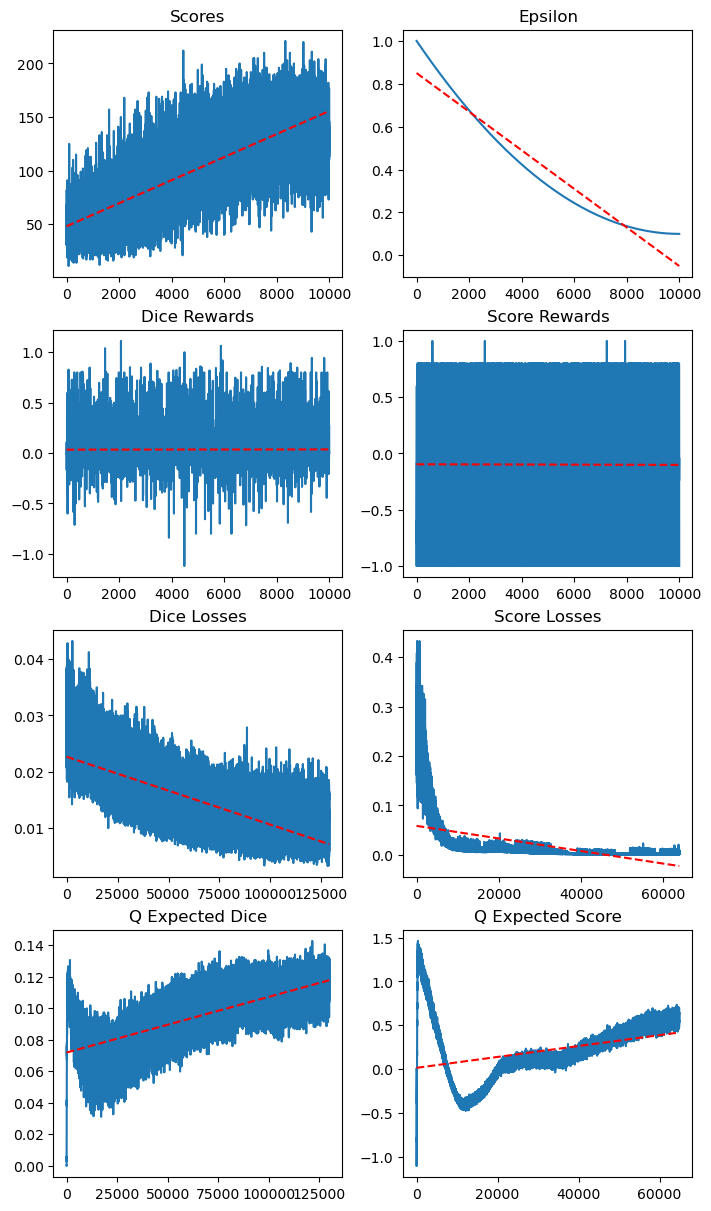

In [22]:
memory_dice_rewards = [x[2] for x in agent.memory_dice.memory]
memory_score_rewards = [x[2] for x in agent.memory_score.memory]
losses_dice = agent.losses_dice[n_episodes//10:]
losses_score = agent.losses_score[n_episodes//10:]
Q_expected_dice = agent.q_values_dice
Q_expected_score = agent.q_values_score

fig, ax = plt.subplots(4, 2, figsize = (7, 12), layout='constrained')

for data, title, ax in zip(
    [scores, eps_history, memory_dice_rewards, memory_score_rewards, losses_dice, losses_score, Q_expected_dice, Q_expected_score],
    ['Scores', 'Epsilon', 'Dice Rewards', 'Score Rewards', 'Dice Losses', 'Score Losses', 'Q Expected Dice', 'Q Expected Score'], 
    ax.ravel()
):
    data = data
    x = np.arange(len(data))
    y = np.array(data)
    coefficients = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coefficients)
    trendline = polynomial(x)
    ax.plot(x, y)
    ax.plot(x, trendline, linestyle='--', color='red')
    ax.set_title(title)

plt.show()

In [23]:
rewards = {}
for i, row in enumerate(agent.memory_dice.memory):
    rewards[i] = row[2]
rewards = dict(sorted(rewards.items(), key=lambda item: item[1], reverse=True)[:10])

for idx in rewards.keys():
    n = idx
    action = agent.memory_dice.memory[n][1]
    binary_string = f"{action:0{5}b}"
    decoded_action = torch.tensor([float(bit) for bit in binary_string])

    print(
        f'First Hand: {[int(die * 6) for die in agent.memory_dice.memory[n][0][:5]]}\n'
        f'Potential Scores: {[int(score * 50) for score in agent.memory_dice.memory[n][0][6:-15]]}\n'
        f'Next Hand: {[int(die * 6) for die in agent.memory_dice.memory[n][3][:5]]}\n'
        f'Potential Scores: {[int(score * 50) for score in agent.memory_dice.memory[n][3][6:-15]]}\n'
        f'Eligible Scores: {agent.memory_dice.memory[n][0][-14:-1]}\n'
        f'Action: {decoded_action}\n'
        f'Reward: {agent.memory_dice.memory[n][2]}\n'
    )

First Hand: [168, 4, 5, 0, 0]
Potential Scores: [0, 5, 0, 0, 0, 0, 0, 0, 0]
Next Hand: [1476, 2, 5, 0, 0]
Potential Scores: [0, 25, 0, 25, 25, 0, 0, 0, 50]
Eligible Scores: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Action: tensor([0., 0., 0., 0., 0.])
Reward: 1.1119999999999999

First Hand: [918, 2, 3, 0, 0]
Potential Scores: [8, 0, 0, 0, 0, 0, 0, 0, 0]
Next Hand: [1386, 0, 3, 0, 0]
Potential Scores: [20, 0, 0, 20, 20, 0, 0, 0, 50]
Eligible Scores: [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]
Action: tensor([0., 1., 1., 0., 0.])
Reward: 1.0639999999999998

First Hand: [366, 4, 1, 0, 0]
Potential Scores: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Next Hand: [756, 2, 1, 0, 0]
Potential Scores: [0, 0, 0, 0, 10, 0, 0, 0, 50]
Eligible Scores: [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
Action: tensor([0., 1., 0., 1., 0.])
Reward: 1.04

First Hand: [558, 4, 0, 0, 0]
Potential Scores: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Next Hand: [1176, 2, 0, 0, 0]
Potential Scores: [0, 0, 0, 0, 0, 0, 0, 0, 50]
Eligible Scores: [1, 1, 1, 1, 

In [24]:
eps = 0.0

# Review decision-making
env.reset_game()

for turn in range(13):
    print(f'Turn: {turn}')
    env.reset_turn()
    
    # First roll
    env.roll_dice()
    print(f'Roll 1: {env.hand}')

    # First dice action - choose dice
    state = env.get_state()
    action_dice = agent.act_dice(state, eps)
    env.update_hand(action_dice)
    binary_string = f"{action_dice:0{5}b}"
    decoded_action = [int(bit) for bit in binary_string]
    print(f'First Dice Action: {action_dice} - {decoded_action} - Hand: {env.hand}')

    # Second roll
    env.roll_dice()
    reward_dice = env.calc_reward_dice(env.score_potentials[0], env.score_potentials[1])
    print(f'Hand After Roll 2: {env.hand} - Reward: {reward_dice}')
    
    # Second dice action - choose dice
    state = env.get_state()
    action_dice = agent.act_dice(state, eps)
    env.update_hand(action_dice)
    binary_string = f"{action_dice:0{5}b}"
    decoded_action = [int(bit) for bit in binary_string]
    print(f'Second Dice Action: {action_dice} - {decoded_action} - Hand: {env.hand}')

    # Final roll
    env.roll_dice()
    reward_dice = env.calc_reward_dice(env.score_potentials[0], env.score_potentials[1])
    print(f'Hand After Roll 3: {env.hand} - Reward: {reward_dice}')

    state = env.get_state()
    action_score = agent.act_score(state, eps)

    # Mark score
    score_decision = env.label_score_dict[action_score]
    score_amount = env.score_potentials[2][score_decision]
    env.mark_score(score_decision, score_amount)
    reward_score = env.calc_reward_score(0, 0, env.score_potentials[-1], score_decision, score_amount)
    print(f'Score Decision: {score_decision} - Score Amount: {score_amount} - Reward: {reward_score}\n\n')

print(f'Total Score: {env.score_card["total_score"]}')

Turn: 0
Roll 1: [4, 2, 6, 4, 4]
First Dice Action: 10 - [0, 1, 0, 1, 0] - Hand: [2, 4]
Hand After Roll 2: [2, 4, 4, 5, 3] - Reward: 0.184
Second Dice Action: 31 - [1, 1, 1, 1, 1] - Hand: [2, 4, 4, 5, 3]
Hand After Roll 3: [2, 4, 4, 5, 3] - Reward: 0.184
Score Decision: small_straight - Score Amount: 30 - Reward: 0.6


Turn: 1
Roll 1: [2, 3, 3, 3, 1]
First Dice Action: 0 - [0, 0, 0, 0, 0] - Hand: []
Hand After Roll 2: [4, 2, 6, 6, 5] - Reward: 0.21600000000000003
Second Dice Action: 20 - [1, 0, 1, 0, 0] - Hand: [4, 6]
Hand After Roll 3: [4, 6, 6, 5, 5] - Reward: 0.21600000000000003
Score Decision: chance - Score Amount: 26 - Reward: 0.44


Turn: 2
Roll 1: [3, 3, 5, 5, 1]
First Dice Action: 21 - [1, 0, 1, 0, 1] - Hand: [3, 5, 1]
Hand After Roll 2: [3, 5, 1, 5, 5] - Reward: 0.22799999999999998
Second Dice Action: 31 - [1, 1, 1, 1, 1] - Hand: [3, 5, 1, 5, 5]
Hand After Roll 3: [3, 5, 1, 5, 5] - Reward: 0.22799999999999998
Score Decision: three_of_a_kind - Score Amount: 19 - Reward: 0.16




In [32]:
def yahtzee_probability(num_matching_dice):
    remaining_dice = 5 - num_matching_dice
    return (1/6) ** remaining_dice

# Example usage:
# Current hand: [2, 2, 2, x, x]
prob_yahtzee = yahtzee_probability(4)
print(f"Probability of Yahtzee: {prob_yahtzee}")

Probability of Yahtzee: 0.16666666666666666


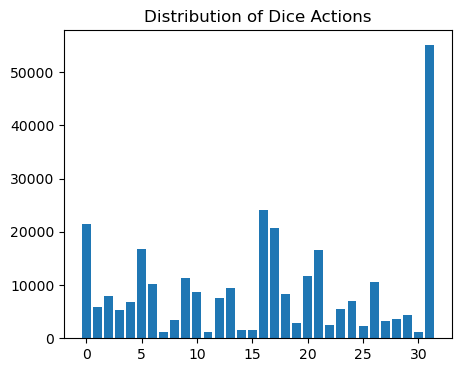

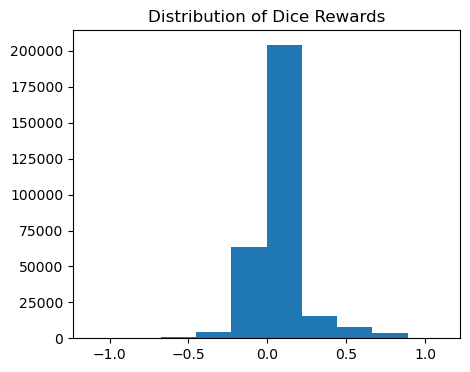

In [25]:
results_df_dice = pd.DataFrame()

for experience in agent.memory_dice.memory:
    state, action, reward, next_state, done = experience
    result = pd.DataFrame({'state': state, 'action': action, 'reward': reward, 'next_state': next_state, 'done': done})
    results_df_dice = pd.concat([results_df_dice, result], ignore_index=True)

plt.figure(figsize=(5, 4))
plt.bar(np.unique(results_df_dice.action, return_counts=True)[0], np.unique(results_df_dice.action, return_counts=True)[1])
plt.title('Distribution of Dice Actions')
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(results_df_dice.reward)
plt.title('Distribution of Dice Rewards')
plt.show()

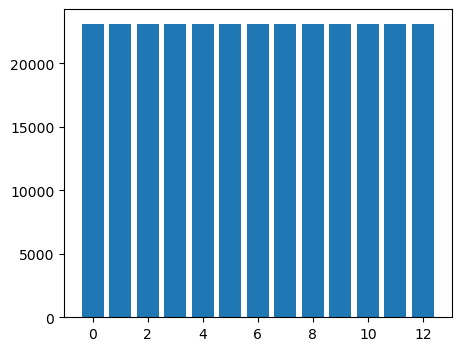

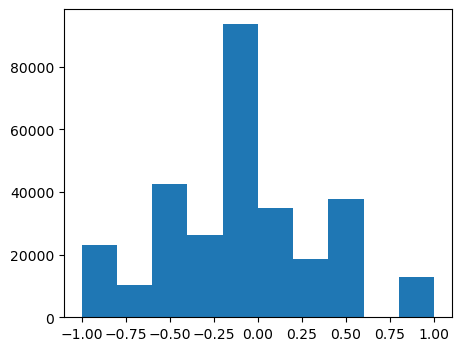

In [26]:
results_df_score = pd.DataFrame()

for experience in agent.memory_score.memory:
    state, action, reward, next_state, done = experience
    result = pd.DataFrame({'state': state, 'action': action, 'reward': reward, 'next_state': next_state, 'done': done})
    results_df_score = pd.concat([results_df_score, result], ignore_index=True)

plt.figure(figsize=(5, 4))
plt.bar(np.unique(results_df_score.action, return_counts=True)[0], np.unique(results_df_score.action, return_counts=True)[1])
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(results_df_score.reward)
plt.show()